In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_to_folder = "ENPM673/tutorials"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/tutorials


Code uses cv2, numpy based methods such as the houghlinesp method to compute the edges and corners of a page in a video and plots them for visualization purposes.

In [ ]:
#This is code that opens the video to process filters out the frames that are below the threshold
import cv2
import numpy as np

video_path = 'assets/proj2_v2.mp4'
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('assets/clear_frames_output_video.mp4', fourcc, 10, (frame_width, frame_height))

#Create the laplacian filter
laplacian_filter = np.array([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]], dtype=np.float32)
#decide the threshold
threshold = 110


while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break


    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #compute the laplacian
    laplacian_result = cv2.filter2D(frame, cv2.CV_32F, laplacian_filter)

    #compute the variance
    laplacian_variance = np.var(laplacian_result)


    #drop the frames that are below the threshold
    if laplacian_variance > threshold:
        out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cap.release()
cv2.destroyAllWindows()

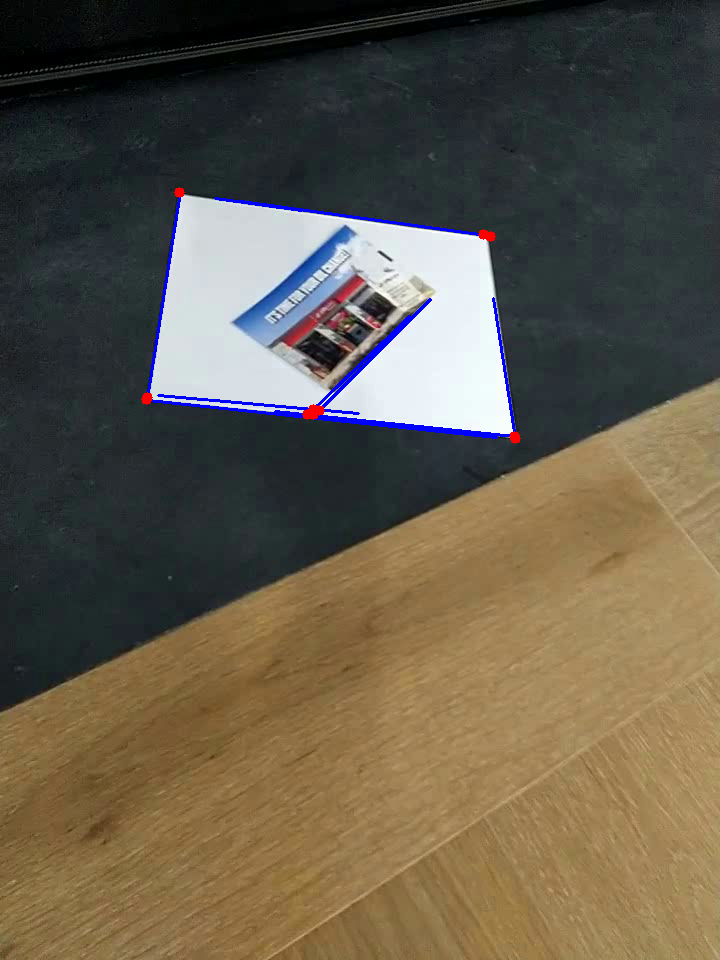

In [ ]:
#This code cell runs the houghlinesp method and plots the intersections
from IPython.display import clear_output
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math


video_path = 'assets/clear_frames_output_video.mp4'
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('assets/hough_lines_output.mp4', fourcc, 10, (frame_width, frame_height))

if not cap.isOpened():
    print("Error opening video file")

lines_list = []
while True:
    ret, frame = cap.read()

    if not ret:
        break

    #Convert the frame to grayscale and then calculate dilation of thresholded image.
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray_frame, 225, 255, cv2.THRESH_BINARY)[1]

    #Below code improves the image for better canny edge detection
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    diff = cv2.absdiff(dilate, thresh)

    edges = 255 - diff

    edges = cv2.Canny(edges, 80, 150)

    #code for comminng up with the y intercept and the slope of line
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=90, minLineLength=50, maxLineGap=20)
    line_info = []
    equation_list = []
    line_points = []
    if (lines is not None):
        lines_list.append(lines)
        for line in lines:
            x1 , y1 , x2 , y2 = line[0]
            line_points.append((x1 , y1 , x2 , y2))
            m = (y2 - y1) / (x2 - x1)
            c = y1 - m * x1
            line_info.append((c , m))
            cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    #logic for coming up with intersections and plotting them on the frame
    intersections = []
    for i in range (len(line_info)):
            j = i + 1
            c1 , m1 = line_info[i]
            while(j < len(line_info)):
                c2 , m2 = line_info[j]
                if (m1 != m2):
                    x = int((c2 - c1) / (m1 - m2))
                    y = int(m1 * x + c1)
                    intersections.append((x , y))
                    center = (x , y)
                    #cv2.circle(frame, center, 5, (0, 0, 255), -1)
                j = j +  1




    #This is some code to get the points that are close to end points. This filters out extraneous points
    threshold_distance = 5  # Adjust this threshold as needed

    for tup in line_points:
         x1 , y1 , x2 , y2 = tup
         for points in intersections:
            x, y = points
            d1 = math.sqrt((x - x1)**2 + (y - y1)**2)
            d2 = math.sqrt((x - x2)**2 + (y - y2)**2)
            if(d1 < threshold_distance):
                cv2.circle(frame, (x , y), 5, (0, 0, 255), -1)
            elif(d2 < threshold_distance):
                cv2.circle(frame , (x , y) , 5 , (0 , 0 , 255) , -1)

    #         distance = abs((m * x - y + c) / np.sqrt(m**2 + 1))  # Point-to-line distance
    #         if distance < threshold_distance:
    #             center = (x, y)
    #             cv2.circle(frame, center, 5, (0, 0, 255), -1)



    cv2_imshow(frame)
    out.write(frame)
    clear_output(True)
out.release()
cap.release()
cv2.destroyAllWindows()

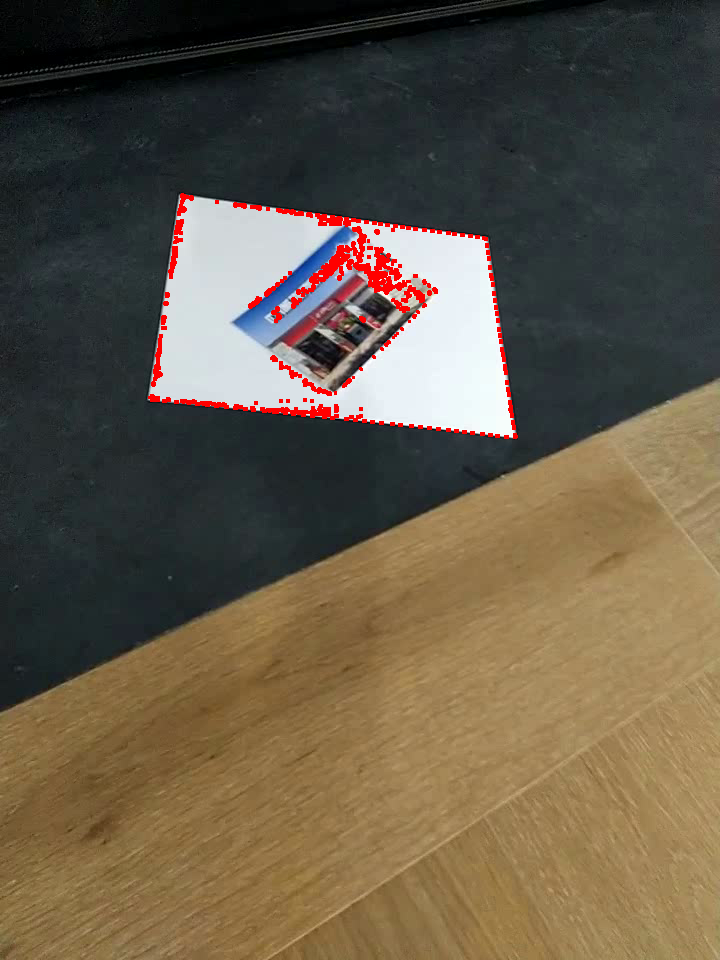

In [ ]:
#this code cell carries out harris corner detection
from IPython.display import clear_output
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math


video_path = 'assets/clear_frames_output_video.mp4'
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('assets/harris_corner_output.mp4', fourcc, 10, (frame_width, frame_height))

if not cap.isOpened():
    print("Error opening video file")

lines_list = []
while True:
    ret, frame = cap.read()

    if not ret:
        break

    #Convert the frame to grayscale.
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray_frame, 225, 255, cv2.THRESH_BINARY)[1]
    #apply harris corner to the thrsholded image
    corners = cv2.cornerHarris(thresh, blockSize=2, ksize=3, k=0.04)
    corners = cv2.dilate(corners, None)

    #Threshold for corner detection
    threshold = 0.01 * corners.max()
    frame[corners > threshold] = [0, 0, 255]

    cv2_imshow(frame)
    out.write(frame)
    clear_output(True)

out.release()
cap.release()
cv2.destroyAllWindows()


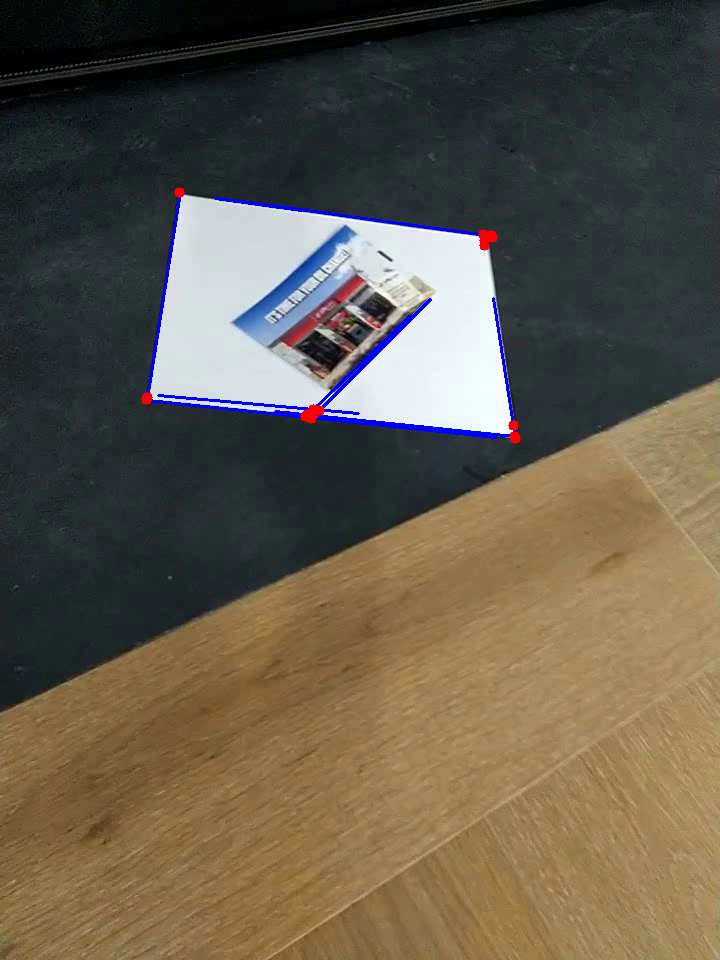

In [ ]:
#Following is code that combines results from houghlines and the corners received through that and the corners received through harris corner detection and filters out unrequired points
#This also implements harris corner detection verification
from IPython.display import clear_output
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math
video_path = 'assets/clear_frames_output_video.mp4'
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('assets/confirmation_output.mp4', fourcc, 10, (frame_width, frame_height))



cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")
lines_list = []
while True:
    # Read a frame from the video
    ret, frame = cap.read()


    if not ret:
        #print('here')
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray_frame, 225, 255, cv2.THRESH_BINARY)[1]

    corners = cv2.cornerHarris(thresh, blockSize=2, ksize=3, k=0.04)
    corners = cv2.dilate(corners, None)

    #Threshold for corner detection
    threshold = 0.01 * corners.max()

    y_coords, x_coords = np.where(corners > threshold)


    #zip to get (x, y) pairs
    corner_coordinates = list(zip(x_coords, y_coords))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    diff = cv2.absdiff(dilate, thresh)

    edges = 255 - diff

    edges = cv2.Canny(edges, 80, 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=90, minLineLength=50, maxLineGap=20)
    line_info = []
    if (lines is not None):
        lines_list.append(lines)
        for line in lines:
            x1 , y1 , x2 , y2 = line[0]
            m = (y2 - y1) / (x2 - x1)
            c = y1 - m * x1
            line_info.append((c , m))
            cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    #logic for coming up with intersections
    intersections = []
    for i in range (len(line_info)):
            j = i + 1
            c1 , m1 = line_info[i]
            while(j < len(line_info)):
                c2 , m2 = line_info[j]
                if (m1 != m2):
                    # print('for one line')
                    x = int((c2 - c1) / (m1 - m2))
                    y = int(m1 * x + c1)
                    intersections.append((x , y))
                    center = (x , y)
                    #cv2.circle(frame, center, 5, (0, 255, 0), -1)
                j = j +  1
    #plot confirmed points only
    for point1 in intersections :
        for point2 in corner_coordinates :
            x1 , y1 = point1
            x2 , y2 = point2
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if (distance <= 5):
                center = point1
                cv2.circle(frame, center, 5, (0, 0, 255), -1)
    #logic for plotting the intersections at the right spots
    # for line in (line_info):
    #     c , m = line
    #     on_line_points = find_points_on_line(intersections, m, c)
    #     points = find_max_distance_points(on_line_points)
    #     #print (points)
    #     if points != None :
    #         point1 , point2 = points
    #         cv2.circle(frame, point1, 5, (255, 0, 0), -1)
    #         cv2.circle(frame, point2, 5, (255, 0, 0), -1)


    #edges_bgr[:, :, :] = [0, 0, 255]
    # Draw the edges on the original frame
    #frame_with_edges = cv2.addWeighted(frame, 1, edges_bgr, 1, 0)

    cv2_imshow(frame)
    out.write(frame)
    clear_output(True)
    #print('frame computation complete')
    #con =  cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2BGR)

    #output_video.write(con)
    #plt.imshow(thresholded_image)
cap.release()
out.release()
cv2.destroyAllWindows()